In [1]:
print("hello world")

hello world


In [2]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

In [3]:
train_dir = r"C:\Users\AMAN\OneDrive\Desktop\Tumor Detection\Training"
test_dir = r"C:\Users\AMAN\OneDrive\Desktop\Tumor Detection\Testing"



In [4]:
print(os.listdir(train_dir))

['glioma', 'meningioma', 'notumor', 'pituitary']


In [5]:
# Load and shuffle the train data
train_paths = []
train_labels = []


print(os.listdir(train_dir))#['glioma', 'meningioma', 'notumor', 'pituitary']


for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))#creates the full path of the image.
        train_labels.append(label)#stores which class that image belongs to (like ['notumor', 'glioma', 'meningioma'--etc])

train_paths, train_labels = shuffle(train_paths, train_labels)#mixes images randomly so the model doesn’t learn any order bias.






# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)



['glioma', 'meningioma', 'notumor', 'pituitary']


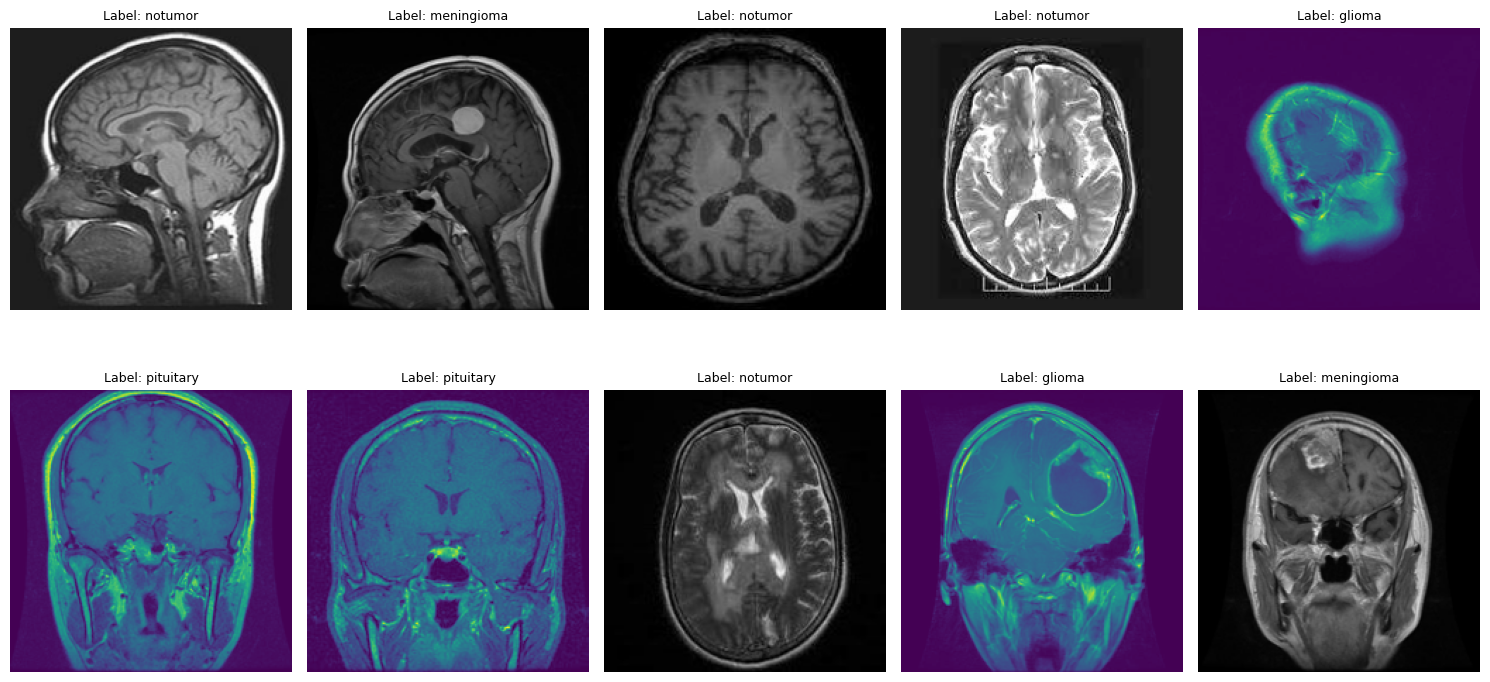

In [6]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Pick 10 random image indices
indices = random.sample(range(len(train_paths)), 10)

# Create grid: 2 rows x 5 cols
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
#axes.ravel() ->converts grid into a single list of 10 boxes.(in each box we will show one random image)
for ax, idx in zip(axes.ravel(), indices):#(axes.ravel(), indices)-> pairs each box (ax) with a random index (idx).
    img = Image.open(train_paths[idx]).resize((200, 200))
    ax.imshow(img)
    ax.set_title(f"Label: {train_labels[idx]}", fontsize=9)#Label for the image
    ax.axis("off")  # remove axis lines

plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import os, random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img, img_to_array


def augment_image(image):
    """Apply random brightness & contrast, return normalized NumPy array."""
    # Convert to PIL(image form)
    image = Image.fromarray(np.uint8(image))# np.uint8 makes sure pixel values are valid (0–255)
    
    # Random Brightness (0.8x to 1.2x)
    if random.random() > 0.5:  
        image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    
    # Random Contrast (0.8x to 1.2x)
    if random.random() > 0.5:  
        image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    
    # Convert back to NumPy (normalized [0,1])
    return np.array(image) / 255.0


def open_images(paths, image_size):
    """Load images from paths, resize & augment."""
    images = []
    for path in paths:
        img = load_img(path, target_size=(image_size, image_size))   # Keras load
        img = img_to_array(img)   # Convert to NumPy
        img = augment_image(img)  # Apply augmentation
        images.append(img)
    return np.array(images, dtype=np.float32)#dtype=np.float32 keeps memory smaller and faster.

def create_label_map(train_dir):
    """Create mapping dictionary {label_name: index}."""
    unique_labels = sorted(os.listdir(train_dir))
    return {label: idx for idx, label in enumerate(unique_labels)}

def encode_label(labels, label_map):
    """Encode labels using pre-computed map."""
    return np.array([label_map[label] for label in labels], dtype=np.int32)


def datagen(paths, labels, label_map, batch_size=12, epochs=1, image_size=128, shuffle=True):#Models can’t eat all data at once, so we feed them mini-batches repeatedly
    """Yield batches of augmented images & encoded labels."""
    data = list(zip(paths, labels))
    
    for _ in range(epochs):
        if shuffle:
            random.shuffle(data)   # Shuffle data each epoch
        
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            batch_paths, batch_labels = zip(*batch)

            # Load + Augment images
            batch_images = open_images(batch_paths, image_size)

            # Encode labels
            batch_labels = encode_label(batch_labels, label_map)

            yield batch_images, batch_labels


In [8]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5
label_map = {label: idx for idx, label in enumerate(['glioma', 'meningioma', 'notumor', 'pituitary'])}
# Train the model
history = model.fit(datagen(train_paths, train_labels,label_map, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - loss: 0.4672 - sparse_categorical_accuracy: 0.8239
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step - loss: 0.2276 - sparse_categorical_accuracy: 0.9194
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - loss: 0.1605 - sparse_categorical_accuracy: 0.9431
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 624s 2s/step - loss: 0.1178 - sparse_categorical_accuracy: 0.9534
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 219s 769ms/step - loss: 0.0815 - sparse_categorical_accuracy: 0.9673


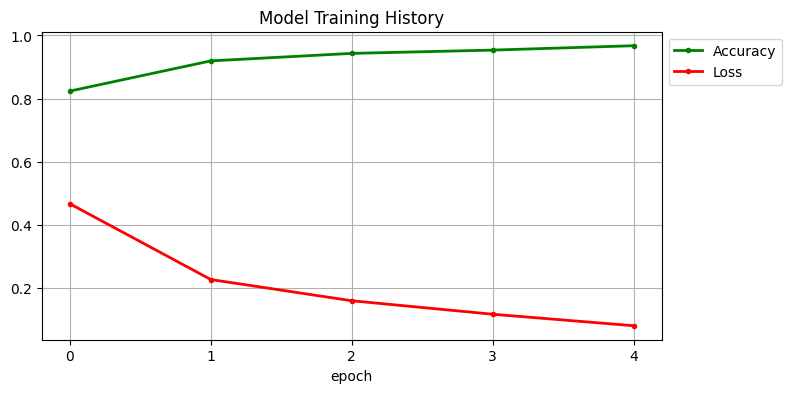

In [9]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths,IMAGE_SIZE)  # Load and augment test images
test_labels_encoded = encode_label(test_labels,label_map=label_map)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 786ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       300
           1       0.82      0.97      0.89       306
           2       0.99      0.98      0.99       405
           3       0.98      0.99      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.94      0.94      1311



In [19]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# # Plot the Confusion Matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.show()

Confusion Matrix:
[[242  58   0   0]
 [  0 296   3   7]
 [  2   5 398   0]
 [  1   3   0 296]]


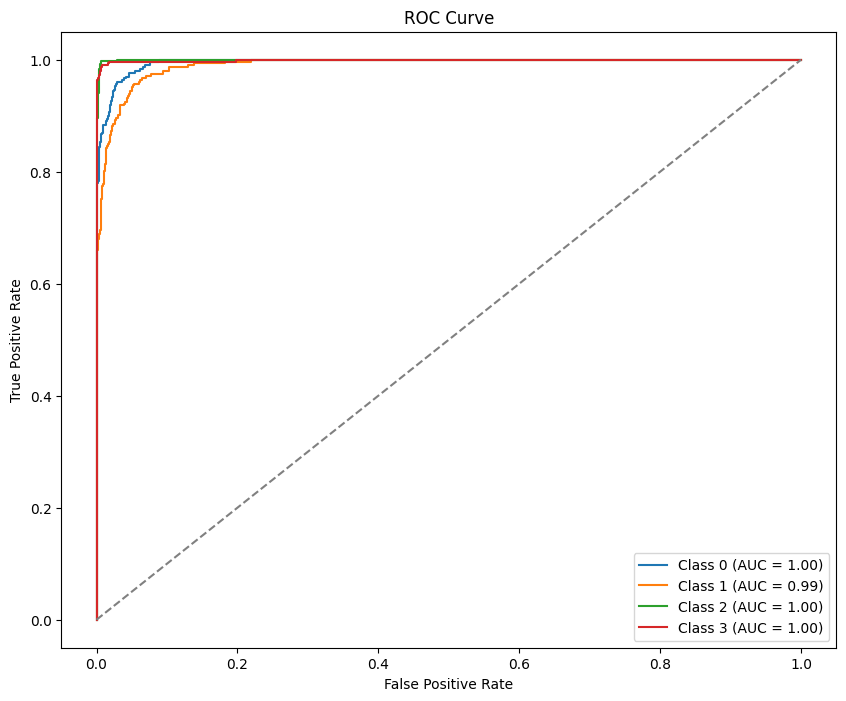

In [15]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [16]:
model.save('model.h5')

In [17]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

In [18]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt


# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))